In [1]:
import tensorflow as tf

In [2]:
#sequential model
from tensorflow.keras.models import Sequential

In [3]:
#ConvNet will end with dense layer and will flatten before feeding to dense layer
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LSTM

In [7]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [8]:
#load file with pickle
import pickle
import time

In [9]:
gpu_options =tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [10]:
pickle_in = open("XMEL.pickle", "rb")
X = pickle.load(pickle_in)
#load X

pickle_in = open("yMEL.pickle", "rb")
y = pickle.load(pickle_in)
#load y

In [11]:
#Data needs to be normalized and since we are using image data we divide by 255 the max value, min value is 0.
X=X/255.0

In [12]:
n_test = 386
trainX64, testX64 = X[:n_test, :], X[n_test:, :]
trainy64, testy64 = y[:n_test], y[n_test:]

In [17]:
dense_layers = [3]
layer_sizes = [16]
conv_layers = [3]
size = 750

In [19]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 9x9 window, input data features
            model.add(Conv2D(layer_size, (9,9), input_shape = X.shape[1:]))
            padding='same'
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 7x7
            model.add(MaxPooling2D(pool_size=(7,7)))
            model.add(Dropout(0.4))
                       
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            opt = Adam(lr=0.0001, decay=1e-6)
            
            model.compile(loss='binary_crossentropy',
                          optimizer=opt,
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 8705 than positives 4862
            class_weights = {0: 1.0,
                            1: 1.0} #8705/4862
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(trainX64, trainy64, class_weight=class_weights, batch_size=5, epochs=30, validation_split=0.3, callbacks=[tensorboard])

2-conv-16-nodes-2-dense-750-dimension-1563935703
Train on 270 samples, validate on 116 samples
Epoch 1/30
270/270 [==============================] - 17s 64ms/step - loss: 0.7275 - acc: 0.5037 - val_loss: 0.6608 - val_acc: 0.5690
Epoch 2/30
270/270 [==============================] - 14s 51ms/step - loss: 0.6128 - acc: 0.6741 - val_loss: 0.6369 - val_acc: 0.6121
Epoch 3/30
270/270 [==============================] - 14s 51ms/step - loss: 0.5583 - acc: 0.7074 - val_loss: 0.6124 - val_acc: 0.6552
Epoch 4/30
270/270 [==============================] - 14s 51ms/step - loss: 0.4851 - acc: 0.7667 - val_loss: 0.5978 - val_acc: 0.6638
Epoch 5/30
270/270 [==============================] - 14s 50ms/step - loss: 0.4838 - acc: 0.7889 - val_loss: 0.6300 - val_acc: 0.6466
Epoch 6/30
270/270 [==============================] - 14s 50ms/step - loss: 0.4600 - acc: 0.7667 - val_loss: 0.6297 - val_acc: 0.7155
Epoch 7/30
270/270 [==============================] - 14s 50ms/step - loss: 0.4005 - acc: 0.8222 - va

In [20]:
# predict probabilities for test set
yhat_probs64 = model.predict(testX64, verbose=0)
# predict crisp classes for test set
yhat_classes64 = model.predict_classes(testX64, verbose=0)
# reduce to 1d array
yhat_probs64 = yhat_probs64[:, 0]
yhat_classes64 = yhat_classes64[:, 0]

ResourceExhaustedError: OOM when allocating tensor with shape[32,16,742,742] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_3/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_3/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_3/Conv2D/ReadVariableOp)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node activation_15/Sigmoid/_551}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_83_activation_15/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

In [22]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy64, yhat_classes64)
print('Accuracy: %.4f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy64, yhat_classes64, average='weighted')
print('Precision: %.4f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy64, yhat_classes64, average='weighted')
print('Recall: %.4f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy64, yhat_classes64, average='weighted')
print('F1 score: %.4f' % f1)
# ROC AUC
auc = roc_auc_score(testy64, yhat_probs64, average='weighted')
print('ROC AUC: %.4f' % auc)

NameError: name 'yhat_classes64' is not defined

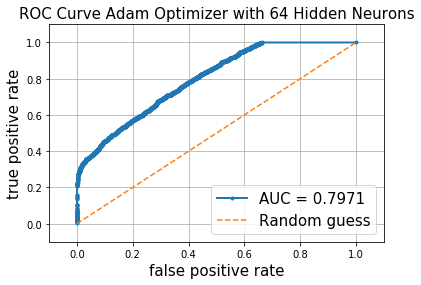

In [15]:
# calculate roc curve
fpr64, tpr64, thresholds64 = roc_curve(testy64, yhat_probs64)
# plot the roc curve for the model
plt.plot(fpr64, tpr64, marker='.', linewidth=2, label='AUC = 0.7971')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.title('ROC Curve Adam Optimizer with 64 Hidden Neurons', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.rcParams["figure.figsize"]=10,8
#plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
# show the plot
plt.show()
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy64, yhat_classes64)
print(cm)

[[2813  533]
 [ 709  792]]


In [23]:
n_test = 386
trainX96, testX96 = X[:n_test, :], X[n_test:, :]
trainy96, testy96 = y[:n_test], y[n_test:]

In [24]:
dense_layers = [3]
layer_sizes = [16]
conv_layers = [3]
size = 750

In [26]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 9x9 window, input data features
            model.add(Conv2D(layer_size, (7,7), input_shape = X.shape[1:]))
            padding='same'
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 7x7
            model.add(MaxPooling2D(pool_size=(5,5)))
            model.add(Dropout(0.3))
                       
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            opt = Adam(lr=0.0001, decay=1e-6)
            
            model.compile(loss='binary_crossentropy',
                          optimizer=opt,
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 8705 than positives 4862
            class_weights = {0: 1.0,
                            1: 1.0} #8705/4862
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(trainX96, trainy96, class_weight=class_weights, batch_size=5, epochs=30, validation_split=0.3, callbacks=[tensorboard])

3-conv-16-nodes-3-dense-750-dimension-1563936365
Train on 270 samples, validate on 116 samples
Epoch 1/30
270/270 [==============================] - 14s 53ms/step - loss: 0.6872 - acc: 0.5704 - val_loss: 0.6448 - val_acc: 0.6379
Epoch 2/30
270/270 [==============================] - 13s 47ms/step - loss: 0.6517 - acc: 0.6296 - val_loss: 0.6435 - val_acc: 0.6638
Epoch 3/30
270/270 [==============================] - 13s 48ms/step - loss: 0.6197 - acc: 0.6741 - val_loss: 0.6456 - val_acc: 0.6121loss: 0.6389 - acc: 0 - ETA: 7s - loss: 0.6 - ETA: 3s - loss: 
Epoch 4/30
270/270 [==============================] - 13s 48ms/step - loss: 0.6182 - acc: 0.6667 - val_loss: 0.6337 - val_acc: 0.63790.6
Epoch 5/30
270/270 [==============================] - 13s 48ms/step - loss: 0.5714 - acc: 0.7148 - val_loss: 0.7145 - val_acc: 0.6293
Epoch 6/30
270/270 [==============================] - 13s 47ms/step - loss: 0.5990 - acc: 0.6778 - val_loss: 0.6170 - val_acc: 0.6552
Epoch 7/30
270/270 [================

In [20]:
# predict probabilities for test set
yhat_probs96 = model.predict(testX96, verbose=0)
# predict crisp classes for test set
yhat_classes96 = model.predict_classes(testX96, verbose=0)
# reduce to 1d array
yhat_probs96 = yhat_probs96[:, 0]
yhat_classes96 = yhat_classes96[:, 0]

In [21]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy96, yhat_classes96)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy96, yhat_classes96, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy96, yhat_classes96, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy96, yhat_classes96, average='weighted')
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(testy96, yhat_probs96, average='weighted')
print('ROC AUC: %f' % auc)

Accuracy: 0.740871
Precision: 0.728385
Recall: 0.740871
F1 score: 0.730587
ROC AUC: 0.787440


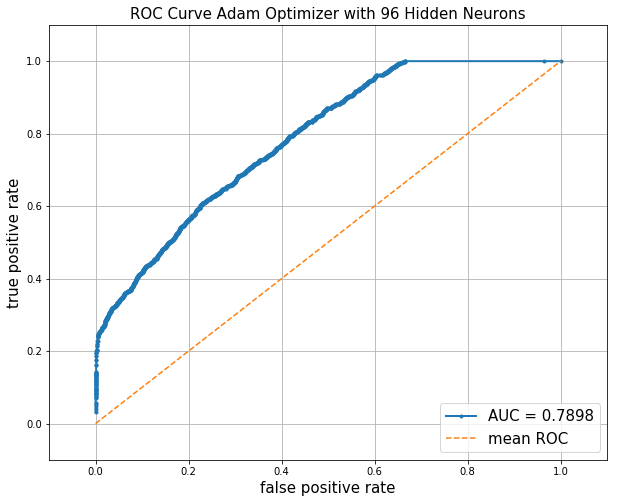

In [22]:
# calculate roc curve
fpr96, tpr96, thresholds96 = roc_curve(testy96, yhat_probs96)
# plot the roc curve for the model
plt.plot(fpr96, tpr96, marker='.', linewidth=2, label='AUC = 0.7898')
plt.plot([0, 1], [0, 1], linestyle='--', label='mean ROC')
plt.title('ROC Curve Adam Optimizer with 96 Hidden Neurons', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.rcParams["figure.figsize"]=10,8
#plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
# show the plot
plt.show()
plt.show()

In [33]:
dense_layers = [2]
layer_sizes = [16]
conv_layers = [2]
size = 750

In [34]:
n_test = 386
trainX128, testX128 = X[:n_test, :], X[n_test:, :]
trainy128, testy128 = y[:n_test], y[n_test:]

In [35]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 9x9 window, input data features
            model.add(Conv2D(layer_size, (9,9), input_shape = X.shape[1:]))
            padding='same'
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 7x7
            model.add(MaxPooling2D(pool_size=(7,7)))
            model.add(Dropout(0.4))
                       
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            opt = Adam(lr=0.001, decay=1e-6)
            
            model.compile(loss='binary_crossentropy',
                          optimizer=opt,
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 8705 than positives 4862
            class_weights = {0: 1.0,
                            1: 1.0} #8705/4862
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(trainX128, trainy128, class_weight=class_weights, batch_size=5, epochs=30, validation_split=0.3, callbacks=[tensorboard])

2-conv-16-nodes-2-dense-750-dimension-1563944471
Train on 270 samples, validate on 116 samples
Epoch 1/30


ResourceExhaustedError: OOM when allocating tensor with shape[5,16,742,742] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_8/Adam/gradients/max_pooling2d_8/MaxPool_grad/MaxPoolGrad}} = MaxPoolGrad[T=DT_FLOAT, data_format="NCHW", ksize=[1, 1, 7, 7], padding="VALID", strides=[1, 1, 7, 7], _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_34/Relu, max_pooling2d_8/MaxPool, training_8/Adam/gradients/AddN_2)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [26]:
# predict probabilities for test set
yhat_probs128 = model.predict(testX128, verbose=0)
# predict crisp classes for test set
yhat_classes128 = model.predict_classes(testX128, verbose=0)
# reduce to 1d array
yhat_probs128 = yhat_probs128[:, 0]
yhat_classes128 = yhat_classes128[:, 0]

In [27]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy128, yhat_classes128)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy128, yhat_classes128, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy128, yhat_classes128, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy128, yhat_classes128, average='weighted')
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(testy128, yhat_probs128, average='weighted')
print('ROC AUC: %f' % auc)

Accuracy: 0.733856
Precision: 0.727905
Recall: 0.733856
F1 score: 0.730310
ROC AUC: 0.791256


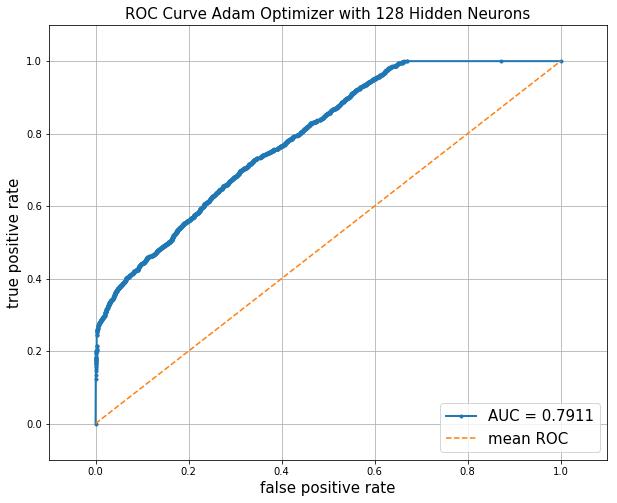

In [28]:
# calculate roc curve
fpr128, tpr128, thresholds128 = roc_curve(testy128, yhat_probs128)
# plot the roc curve for the model
plt.plot(fpr128, tpr128, marker='.', linewidth=2, label='AUC = 0.7911')
plt.plot([0, 1], [0, 1], linestyle='--', label='mean ROC')
plt.title('ROC Curve Adam Optimizer with 128 Hidden Neurons', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.rcParams["figure.figsize"]=10,8
#plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
# show the plot
plt.show()
plt.show()

In [29]:
n_test = 25000
trainX192, testX192 = X[:n_test, :], X[n_test:, :]
trainy192, testy192 = y[:n_test], y[n_test:]

In [30]:
dense_layers = [2]
layer_sizes = [32]
conv_layers = [2]
size = 100

In [31]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 9x9 window, input data features
            model.add(Conv2D(layer_size, (9,9), input_shape = X.shape[1:]))
            padding='same'
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 7x7
            model.add(MaxPooling2D(pool_size=(7,7)))
            model.add(Dropout(0.4))
                       
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            opt = Adam(lr=0.0001, decay=1e-6)
            
            model.compile(loss='binary_crossentropy',
                          optimizer=opt,
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 8705 than positives 4862
            class_weights = {0: 1.0,
                            1: 1.0} #8705/4862
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(trainX192, trainy192, class_weight=class_weights, batch_size=5, epochs=30, validation_split=0.3, callbacks=[tensorboard])

2-conv-192-nodes-2-dense-100-dimension-1560220767
Train on 17500 samples, validate on 7500 samples
Epoch 1/30
17500/17500 [==============================] - 70s 4ms/step - loss: 0.5172 - acc: 0.7211 - val_loss: 0.4818 - val_acc: 0.7437
Epoch 2/30
17500/17500 [==============================] - 68s 4ms/step - loss: 0.4731 - acc: 0.7561 - val_loss: 0.4668 - val_acc: 0.7589
Epoch 3/30
17500/17500 [==============================] - 70s 4ms/step - loss: 0.4557 - acc: 0.7660 - val_loss: 0.4702 - val_acc: 0.7624
Epoch 4/30
17500/17500 [==============================] - 69s 4ms/step - loss: 0.4460 - acc: 0.7735 - val_loss: 0.4671 - val_acc: 0.7421
Epoch 5/30
17500/17500 [==============================] - 69s 4ms/step - loss: 0.4379 - acc: 0.7775 - val_loss: 0.4492 - val_acc: 0.7687
Epoch 6/30
17500/17500 [==============================] - 68s 4ms/step - loss: 0.4302 - acc: 0.7813 - val_loss: 0.4459 - val_acc: 0.7701
Epoch 7/30
17500/17500 [==============================] - 68s 4ms/step - loss: 

In [32]:
# predict probabilities for test set
yhat_probs192 = model.predict(testX192, verbose=0)
# predict crisp classes for test set
yhat_classes192 = model.predict_classes(testX192, verbose=0)
# reduce to 1d array
yhat_probs192 = yhat_probs192[:, 0]
yhat_classes192 = yhat_classes192[:, 0]

In [33]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy192, yhat_classes192)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy192, yhat_classes192, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy192, yhat_classes192, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy192, yhat_classes192, average='weighted')
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(testy192, yhat_probs192, average='weighted')
print('ROC AUC: %f' % auc)

Accuracy: 0.733856
Precision: 0.731300
Recall: 0.733856
F1 score: 0.732484
ROC AUC: 0.792437


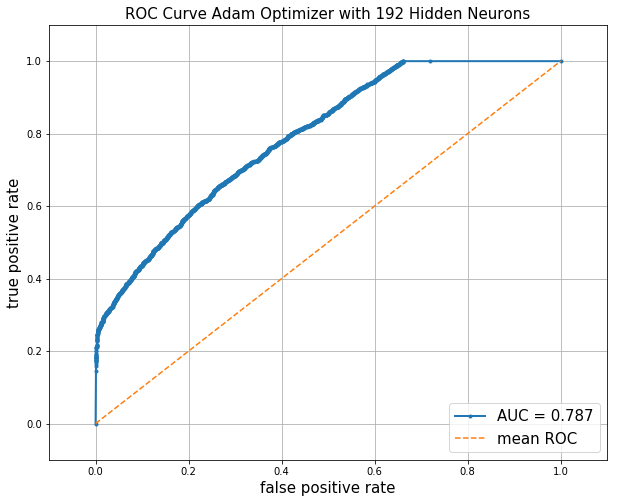

In [34]:
# calculate roc curve
fpr192, tpr192, thresholds192 = roc_curve(testy192, yhat_probs192)
# plot the roc curve for the model
plt.plot(fpr192, tpr192, marker='.', linewidth=2, label='AUC = 0.787')
plt.plot([0, 1], [0, 1], linestyle='--', label='mean ROC')
plt.title('ROC Curve Adam Optimizer with 192 Hidden Neurons', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.rcParams["figure.figsize"]=10,8
#plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
# show the plot
plt.show()
plt.show()

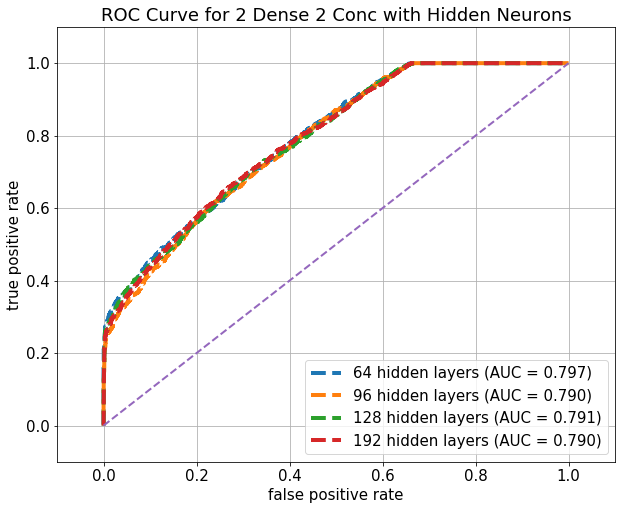

In [35]:
# calculate roc curve

fpr64, tpr64, thresholds64 = roc_curve(testy64, yhat_probs64)
fpr96, tpr96, thresholds96 = roc_curve(testy96, yhat_probs96)
fpr128, tpr128, thresholds128 = roc_curve(testy128, yhat_probs128)
fpr192, tpr192, thresholds192 = roc_curve(testy192, yhat_probs192)
# plot the roc curve for the model
plt.plot(fpr64, tpr64, linestyle='--', linewidth=4, label='64 hidden layers (AUC = 0.797)')
plt.plot(fpr96, tpr96, linestyle='--', linewidth=4, label='96 hidden layers (AUC = 0.790)')
plt.plot(fpr128, tpr128, linestyle='--', linewidth=4, label='128 hidden layers (AUC = 0.791)')
plt.plot(fpr192, tpr192, linestyle='--', linewidth=4, label='192 hidden layers (AUC = 0.790)')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
plt.title('ROC Curve for 2 Dense 2 Conc with Hidden Neurons', fontsize=18)
plt.legend(loc="lower right", fontsize=15)
plt.rcParams["figure.figsize"]=12,8
#plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
# show the plot
plt.show()
plt.show()

In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

f1=0.726 auc=0.795 ap=0.683
f1=0.727 auc=0.795 ap=0.685
f1=0.739 auc=0.795 ap=0.684
f1=0.740 auc=0.795 ap=0.688


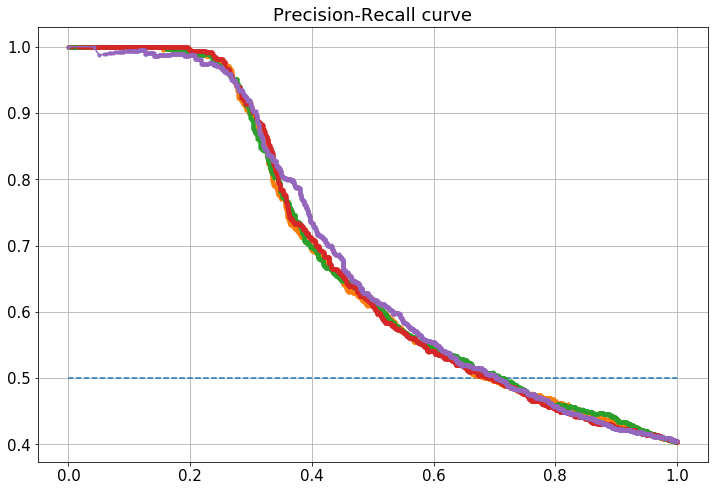

In [40]:
# calculate precision-recall curve
precision1, recall1, thresholds1 = precision_recall_curve(testy64, yhat_probs64)
precision2, recall2, thresholds2 = precision_recall_curve(testy96, yhat_probs96)
precision3, recall3, thresholds3 = precision_recall_curve(testy128, yhat_probs128)
precision4, recall4, thresholds4 = precision_recall_curve(testy192, yhat_probs192)
# calculate F1 score
f1_64 = f1_score(testy64, yhat_classes64, average='weighted')
f1_96 = f1_score(testy96, yhat_classes96, average='weighted')
f1_128 = f1_score(testy128, yhat_classes128, average='weighted')
f1_192 = f1_score(testy192, yhat_classes192, average='weighted')
# calculate precision-recall AUC
#auc = auc(recall, precision, average='weighted')
auc64=roc_auc_score(testy64, yhat_probs64, average='weighted')
auc96=roc_auc_score(testy96, yhat_probs96, average='weighted')
auc128=roc_auc_score(testy128, yhat_probs128, average='weighted')
auc192=roc_auc_score(testy192, yhat_probs192, average='weighted')
# calculate average precision score
ap1 = average_precision_score(testy64, yhat_probs64, average='weighted')
ap2 = average_precision_score(testy96, yhat_probs96, average='weighted')
ap3 = average_precision_score(testy128, yhat_probs128, average='weighted')
ap4 = average_precision_score(testy192, yhat_probs192, average='weighted')
print('f1=%.3f auc=%.3f ap=%.3f' % (f1_64, auc64, ap1))
print('f1=%.3f auc=%.3f ap=%.3f' % (f1_96, auc64, ap2))
print('f1=%.3f auc=%.3f ap=%.3f' % (f1_128, auc64, ap3))
print('f1=%.3f auc=%.3f ap=%.3f' % (f1_192, auc64, ap4))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall1, precision1, marker='.')
plt.plot(recall2, precision2, marker='.')
plt.plot(recall3, precision3, marker='.')
plt.plot(recall4, precision4, marker='.')
plt.title('Precision-Recall curve', fontsize=18)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# show the plot
plt.show()

In [17]:
dense_layers = [1,2,3]
layer_sizes = [64]
conv_layers = [1,2,3]
size = 100

In [12]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (9,9), input_shape = X.shape[1:]))
            padding='same'
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(7,7)))
            model.add(Dropout(0.3))
            
            #Conv layer, activation and pooling layers 2
            #for l in range(conv_layer-1):
             #   model.add(Conv2D(layer_size, (7,7)))
             #   model.add(Activation("relu"))
             #   model.add(MaxPooling2D(pool_size=(5,5)))
             #   model.add(Dropout(0.1))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='Adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 8705 than positives 4862
            class_weights = {0: 1.0,
                            1: 1.8} #8705/4862
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(trainX, trainy, class_weight=class_weights, batch_size=20, epochs=30, validation_split=0.3, callbacks=[tensorboard])

1-conv-32-nodes-2-dense-100-dimension-1555551030
Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 23s 1ms/step - loss: 0.5539 - acc: 0.6586 - val_loss: 0.5220 - val_acc: 0.7077
Epoch 2/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.5213 - acc: 0.7060 - val_loss: 0.5168 - val_acc: 0.7175
Epoch 3/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.5162 - acc: 0.7167 - val_loss: 0.5158 - val_acc: 0.7299
Epoch 4/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.5119 - acc: 0.7259 - val_loss: 0.5070 - val_acc: 0.7259
Epoch 5/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.5053 - acc: 0.7317 - val_loss: 0.5074 - val_acc: 0.7416
Epoch 6/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.4986 - acc: 0.7392 - val_loss: 0.5028 - val_acc: 0.7363
Epoch 7/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 92, 64)        15616     
_________________________________________________________________
activation (Activation)      (None, 92, 92, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                692288    
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
__________

In [19]:
# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [62]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.714137
Precision: 0.603194
Recall: 0.714137
F1 score: 0.650706


In [63]:
# ROC AUC
auc = roc_auc_score(testy, yhat_probs, average='weighted')
print('ROC AUC: %f' % auc)

ROC AUC: 0.619653


No handles with labels found to put in legend.


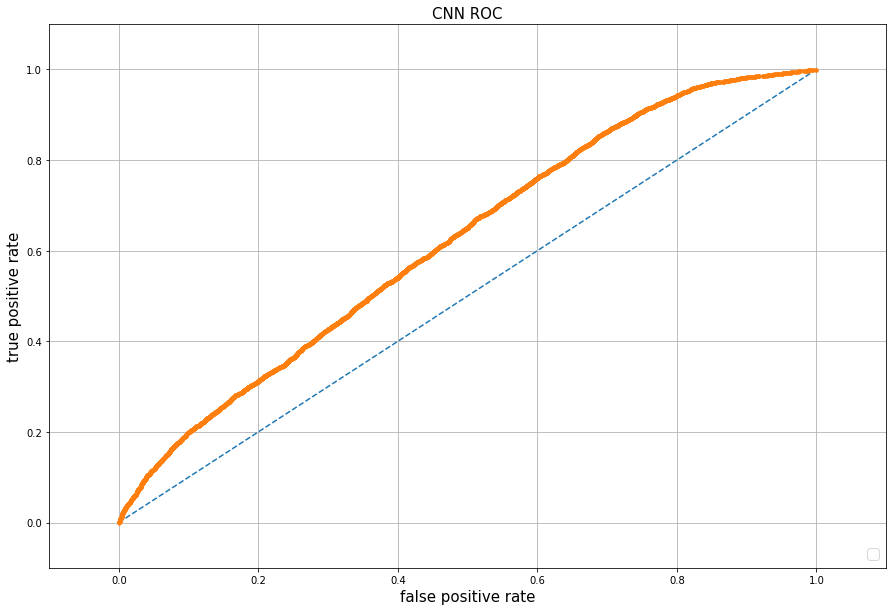

In [120]:
import matplotlib.pyplot as plt

# calculate roc curve
fpr, tpr, thresholds = roc_curve(testy, yhat_probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', linewidth=2)
plt.title('CNN ROC', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.rcParams["figure.figsize"]=15,10
#plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
# show the plot
plt.show()

In [117]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

f1=0.651 auc=0.620 ap=0.378


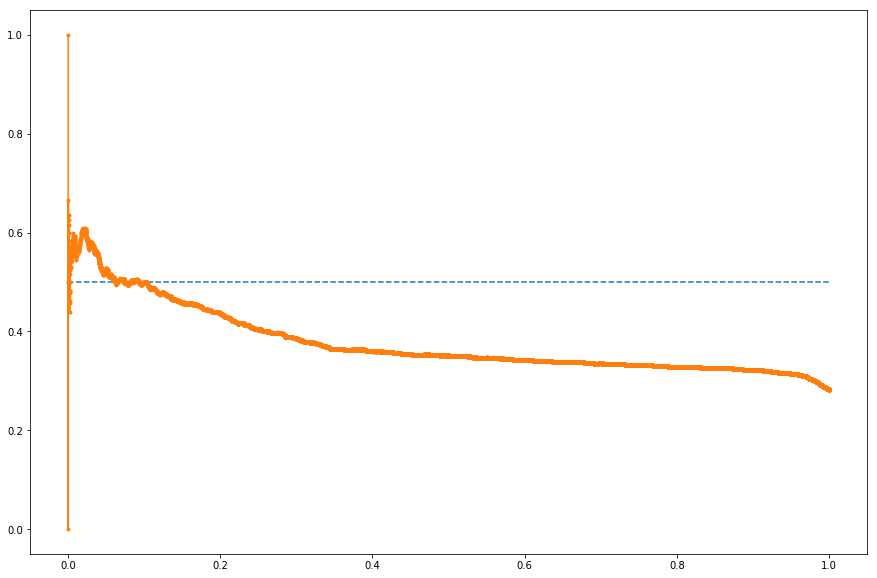

In [118]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, yhat_probs)
# calculate F1 score
f1 = f1_score(testy, yhat_classes, average='weighted')
# calculate precision-recall AUC
#auc = auc(recall, precision, average='weighted')
auc=roc_auc_score(testy, yhat_probs, average='weighted')
# calculate average precision score
ap = average_precision_score(testy, yhat_probs, average='weighted')
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()